In [1]:
import numpy as np
import librosa
from scipy import stats, signal
import pandas as pd
from scipy.fft import fft
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [3]:
def extract_enhanced_mfcc_features(mfcc_matrix):
    """
    Extract enhanced features from MFCC coefficients matrix, specifically designed
    for music and voice classification.
    
    Parameters:
    mfcc_matrix: numpy array of shape (20, n_timestamps)
        The MFCC coefficients matrix
    
    Returns:
    dict: Dictionary containing extracted features
    """
    features = {}
    
    # 1. Basic Statistical Features (from previous code)
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # Calculate first-order deltas (velocity)
        delta = librosa.feature.delta(coeff.reshape(1, -1), width=19)
        
        # Calculate second-order deltas (acceleration)
        delta_delta = librosa.feature.delta(delta, order=2, width=19)
        
        # Basic statistics for original coefficients
        features[f'mfcc{i}_mean'] = np.mean(coeff)
        features[f'mfcc{i}_std'] = np.std(coeff)
        features[f'mfcc{i}_median'] = np.median(coeff)
        
        # Statistics for deltas (velocity features)
        features[f'mfcc{i}_delta_mean'] = np.mean(delta)
        features[f'mfcc{i}_delta_std'] = np.std(delta)
        features[f'mfcc{i}_delta_max'] = np.max(np.abs(delta))
        
        # Statistics for delta-deltas (acceleration features)
        features[f'mfcc{i}_delta2_mean'] = np.mean(delta_delta)
        features[f'mfcc{i}_delta2_std'] = np.std(delta_delta)
        features[f'mfcc{i}_delta2_max'] = np.max(np.abs(delta_delta))
        
        # Temporal variation features
        features[f'mfcc{i}_delta_zero_crossings'] = np.sum(np.diff(np.signbit(delta)))
        features[f'mfcc{i}_delta2_zero_crossings'] = np.sum(np.diff(np.signbit(delta_delta)))
        
        # Energy-related features
        features[f'mfcc{i}_delta_energy'] = np.sum(delta ** 2)
        features[f'mfcc{i}_delta2_energy'] = np.sum(delta_delta ** 2)
        
        # Ratio features
        features[f'mfcc{i}_delta_energy_ratio'] = features[f'mfcc{i}_delta_energy'] / np.sum(coeff ** 2)
        features[f'mfcc{i}_delta2_energy_ratio'] = features[f'mfcc{i}_delta2_energy'] / features[f'mfcc{i}_delta_energy']

    # 2. Rhythm-based Features
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # Detect peaks in the coefficient
        peaks, _ = signal.find_peaks(coeff)
        if len(peaks) > 1:
            # Average distance between peaks (rhythm indicator)
            features[f'mfcc{i}_peak_distance_mean'] = np.mean(np.diff(peaks))
            features[f'mfcc{i}_peak_distance_std'] = np.std(np.diff(peaks))
        else:
            features[f'mfcc{i}_peak_distance_mean'] = 0
            features[f'mfcc{i}_peak_distance_std'] = 0
        
        # Number of peaks normalized by length
        features[f'mfcc{i}_peak_density'] = len(peaks) / len(coeff)
    
    # 3. Spectral Features
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # FFT for frequency analysis
        fft_vals = np.abs(fft(coeff))
        
        # Spectral centroid (brightness of sound)
        freqs = np.fft.fftfreq(len(coeff))
        features[f'mfcc{i}_spectral_centroid'] = np.sum(freqs * fft_vals) / np.sum(fft_vals)
        
        # Spectral rolloff (shape of spectrum)
        cumsum = np.cumsum(fft_vals)
        rolloff_point = np.where(cumsum >= 0.85 * cumsum[-1])[0][0]
        features[f'mfcc{i}_spectral_rolloff'] = rolloff_point / len(fft_vals)
    
    # 4. Temporal Segmentation Features
    segment_size = mfcc_matrix.shape[1] // 3  # Split into three segments
    
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # Features for beginning, middle, and end of song
        features[f'mfcc{i}_begin_mean'] = np.mean(coeff[:segment_size])
        features[f'mfcc{i}_middle_mean'] = np.mean(coeff[segment_size:2*segment_size])
        features[f'mfcc{i}_end_mean'] = np.mean(coeff[2*segment_size:])
    
    # 5. Cross-MFCC Dynamic Features
    # Compute pairwise differences between consecutive frames
    deltas = np.diff(mfcc_matrix, axis=1)
    
    # Overall dynamics
    features['total_dynamics'] = np.mean(np.abs(deltas))
    features['dynamics_std'] = np.std(deltas)
    
    # Compute acceleration (second-order differences)
    accel = np.diff(deltas, axis=1)
    features['total_acceleration'] = np.mean(np.abs(accel))
    features['acceleration_std'] = np.std(accel)
    
    # 6. Structural Features
    # Silence detection (low energy frames)
    energy = np.sum(mfcc_matrix ** 2, axis=0)
    silence_threshold = np.mean(energy) * 0.1
    silence_frames = np.sum(energy < silence_threshold)
    features['silence_ratio'] = silence_frames / len(energy)
    
    # Variation over time windows
    window_size = min(100, mfcc_matrix.shape[1] // 10)
    for i in range(0, 20, 4):  # Take every 4th coefficient to reduce dimensionality
        coeff = mfcc_matrix[i, :]
        windows = np.array_split(coeff, 10)  # Split into 10 windows
        window_means = [np.mean(w) for w in windows]
        features[f'mfcc{i}_temporal_variation'] = np.std(window_means)
    
    return features

def get_feature_importance(X, y, n_estimators=100):
    """
    Train a Random Forest classifier and return feature importance
    """
    from sklearn.ensemble import RandomForestClassifier
    
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance_dict = dict(zip(X.columns, rf.feature_importances_))
    return dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

def visualize_features(features_df, target_labels=None):
    """
    Create visualizations of the features
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Select top numerical columns (exclude file_name and other non-numeric)
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(features_df[numeric_cols].corr(), cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    if target_labels is not None:
        # Box plots for top features by class
        for col in numeric_cols[:5]:  # Plot top 5 features
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=target_labels, y=features_df[col])
            plt.title(f'{col} Distribution by Class')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

In [4]:
import glob
import re

# Define a key function that extracts numbers from the file name
def natural_sort_key(file_name):
    return [int(num) if num.isdigit() else num for num in re.split(r'(\d+)', file_name)]

# Get all the csv files and sort them naturally
file_names = sorted(glob.glob('*.csv'), key=natural_sort_key)

features_df = pd.DataFrame([extract_enhanced_mfcc_features(pd.read_csv(f, header=None).values) 
                          for f in file_names])


In [5]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(features_df)
data_standardized_df = pd.DataFrame(data_standardized, columns=features_df.columns)
# data_standardized_df.to_csv("test_data_features.csv")


In [6]:
def cluster_and_visualize(features_df, file_names, n_clusters=6):
    """
    Perform clustering and create visualizations
    
    Parameters:
    features_df: DataFrame containing only numerical features
    file_names: list of file names corresponding to the features
    n_clusters: number of clusters to create
    """
    # Prepare data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_df)
    
    # Perform clustering
    # 1. K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=20, n_init=100)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    # 2. Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(X_scaled)
    
    # Calculate distance matrix
    dist_matrix = euclidean_distances(X_scaled)
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # 1. Distance matrix heatmap
    plt.subplot(131)
    sns.heatmap(dist_matrix, cmap='coolwarm', center=0)
    plt.title('Euclidean Distance Heatmap')
    
    # 2. K-means cluster visualization
    plt.subplot(132)
    cluster_matrix = np.zeros((len(kmeans_labels), len(kmeans_labels)))
    for i in range(len(kmeans_labels)):
        for j in range(len(kmeans_labels)):
            cluster_matrix[i, j] = kmeans_labels[i] == kmeans_labels[j]
    sns.heatmap(cluster_matrix, cmap='coolwarm')
    plt.title('K-means Clusters')
    
    # 3. Hierarchical cluster visualization
    plt.subplot(133)
    cluster_matrix = np.zeros((len(hierarchical_labels), len(hierarchical_labels)))
    for i in range(len(hierarchical_labels)):
        for j in range(len(hierarchical_labels)):
            cluster_matrix[i, j] = hierarchical_labels[i] == hierarchical_labels[j]
    sns.heatmap(cluster_matrix, cmap='coolwarm')
    plt.title('Hierarchical Clusters')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'kmeans_labels': kmeans_labels,
        'hierarchical_labels': hierarchical_labels,
        'distance_matrix': dist_matrix
    }

def analyze_clusters(file_names, labels, distance_matrix):
    """
    Analyze the contents of each cluster
    """
    results = {}
    
    # For each cluster
    for cluster_id in np.unique(labels):
        # Get indices of files in this cluster
        cluster_indices = np.where(labels == cluster_id)[0]
        
        # Get file names in this cluster
        cluster_files = [file_names[i] for i in cluster_indices]
        
        # Calculate average distance within cluster
        cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
        avg_distance = np.mean(cluster_distances)
        
        results[f'Cluster_{cluster_id}'] = {
            'size': len(cluster_files),
            'files': cluster_files,
            'avg_distance': avg_distance
        }
    
    return results

def create_detailed_heatmap(distance_matrix, file_names, labels=None):
    """
    Create a detailed heatmap with song labels and cluster information
    """
    plt.figure(figsize=(12, 10))
    
    # Sort by cluster if labels are provided
    if labels is not None:
        sort_idx = np.argsort(labels)
        distance_matrix = distance_matrix[sort_idx][:, sort_idx]
        file_names = [file_names[i] for i in sort_idx]
    
    # Create heatmap
    sns.heatmap(distance_matrix, 
                xticklabels=[f.split('/')[-1] for f in file_names],  # Show only filename, not full path
                yticklabels=[f.split('/')[-1] for f in file_names],
                cmap='coolwarm',
                center=0)
    
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title('Song Similarity Heatmap')
    plt.tight_layout()
    plt.show()

In [9]:
def calculate_dunn_index(X, labels):
    """
    Calculate the Dunn Index for clustering evaluation.
    
    Parameters:
    X : array-like of shape (n_samples, n_features)
        The input samples.
    labels : array-like of shape (n_samples,)
        The cluster labels.
    
    Returns:
    float : The Dunn Index score
    """
    distances = pdist(X)
    dist_matrix = squareform(distances)
    
    unique_labels = np.unique(labels)
    
    # Calculate minimum inter-cluster distance
    min_inter_cluster = float('inf')
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster1_idx = np.where(labels == unique_labels[i])[0]
            cluster2_idx = np.where(labels == unique_labels[j])[0]
            
            distances = dist_matrix[np.ix_(cluster1_idx, cluster2_idx)]
            min_dist = np.min(distances)
            min_inter_cluster = min(min_inter_cluster, min_dist)
    
    # Calculate maximum intra-cluster distance
    max_intra_cluster = 0
    for label in unique_labels:
        cluster_idx = np.where(labels == label)[0]
        if len(cluster_idx) > 1:
            distances = dist_matrix[np.ix_(cluster_idx, cluster_idx)]
            max_dist = np.max(distances)
            max_intra_cluster = max(max_intra_cluster, max_dist)
    
    return min_inter_cluster / max_intra_cluster if max_intra_cluster != 0 else 0

def evaluate_clustering(X, labels, method_name=""):
    """
    Evaluate clustering results using multiple metrics.
    
    Parameters:
    X : array-like of shape (n_samples, n_features)
        The input samples.
    labels : array-like of shape (n_samples,)
        The cluster labels.
    method_name : str
        Name of the clustering method for reporting.
    
    Returns:
    dict : Dictionary containing all evaluation metrics
    """
    metrics = {}
    
    # Silhouette Score
    metrics['silhouette'] = silhouette_score(X, labels)
    
    # Davies-Bouldin Index
    metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    
    # Dunn Index
    metrics['dunn'] = calculate_dunn_index(X, labels)
    
    # Calinski-Harabasz Index
    metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    
    return metrics

def print_clustering_metrics(metrics, method_name=""):
    """
    Print clustering evaluation metrics in a formatted way.
    
    Parameters:
    metrics : dict
        Dictionary containing the evaluation metrics
    method_name : str
        Name of the clustering method
    """
    print(f"\n{'-'*20} Clustering Evaluation: {method_name} {'-'*20}")
    print(f"Silhouette Score: {metrics['silhouette']:.3f}")
    print(f"Davies-Bouldin Index: {metrics['davies_bouldin']:.3f}")
    print(f"Dunn Index: {metrics['dunn']:.3f}")
    print(f"Calinski-Harabasz Index: {metrics['calinski_harabasz']:.3f}")

def find_optimal_clusters(X, k_range=range(2, 11)):
    """
    Find the optimal number of clusters using multiple evaluation metrics.
    
    Parameters:
    X : array-like of shape (n_samples, n_features)
        The input samples.
    k_range : range
        Range of number of clusters to test.
    
    Returns:
    dict : Dictionary containing optimal k values for each metric
    """
    results = {
        'silhouette': [],
        'davies_bouldin': [],
        'dunn': [],
        'calinski_harabasz': []
    }
    
    for k in k_range:
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        # Calculate metrics
        metrics = evaluate_clustering(X, labels)
        for metric_name, value in metrics.items():
            results[metric_name].append(value)
    
    # Find optimal k for each metric
    optimal_k = {
        'silhouette': k_range[np.argmax(results['silhouette'])],
        'davies_bouldin': k_range[np.argmin(results['davies_bouldin'])],
        'dunn': k_range[np.argmax(results['dunn'])],
        'calinski_harabasz': k_range[np.argmax(results['calinski_harabasz'])]
    }
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(221)
    plt.plot(k_range, results['silhouette'])
    plt.title('Silhouette Score\n(higher is better)')
    plt.axvline(optimal_k['silhouette'], color='r', linestyle='--')
    
    plt.subplot(222)
    plt.plot(k_range, results['davies_bouldin'])
    plt.title('Davies-Bouldin Index\n(lower is better)')
    plt.axvline(optimal_k['davies_bouldin'], color='r', linestyle='--')
    
    plt.subplot(223)
    plt.plot(k_range, results['dunn'])
    plt.title('Dunn Index\n(higher is better)')
    plt.axvline(optimal_k['dunn'], color='r', linestyle='--')
    
    plt.subplot(224)
    plt.plot(k_range, results['calinski_harabasz'])
    plt.title('Calinski-Harabasz Index\n(higher is better)')
    plt.axvline(optimal_k['calinski_harabasz'], color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    return optimal_k, results

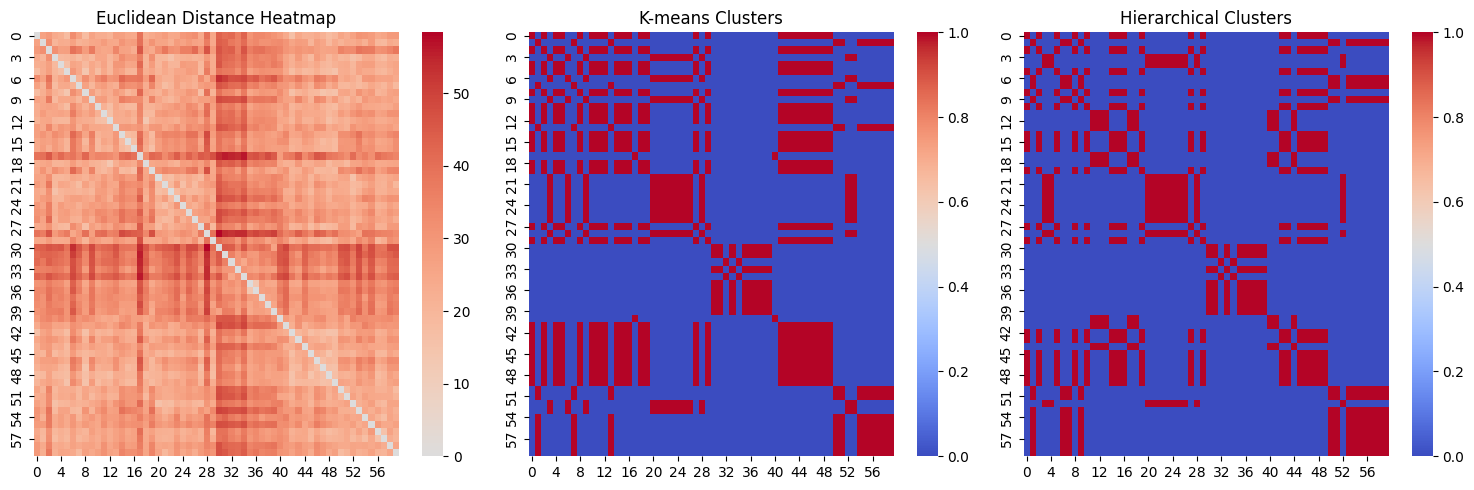

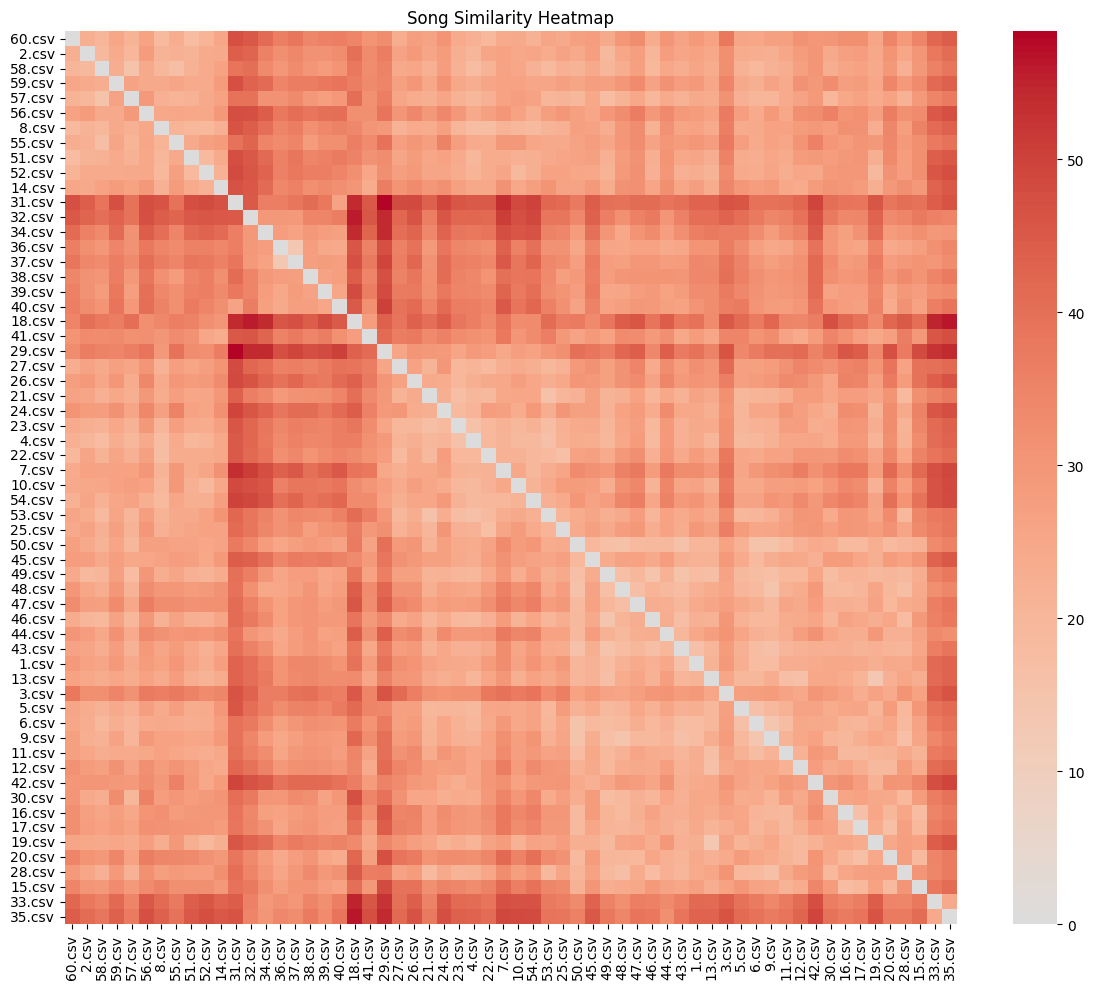


Cluster_0:
Size: 11
Average distance: 21.07
Files:
  - 2.csv
  - 8.csv
  - 14.csv
  - 51.csv
  - 52.csv
  - 55.csv
  - 56.csv
  - 57.csv
  - 58.csv
  - 59.csv
  - 60.csv

Cluster_1:
Size: 8
Average distance: 26.50
Files:
  - 31.csv
  - 32.csv
  - 34.csv
  - 36.csv
  - 37.csv
  - 38.csv
  - 39.csv
  - 40.csv

Cluster_2:
Size: 2
Average distance: 14.01
Files:
  - 18.csv
  - 41.csv

Cluster_3:
Size: 13
Average distance: 21.30
Files:
  - 4.csv
  - 7.csv
  - 10.csv
  - 21.csv
  - 22.csv
  - 23.csv
  - 24.csv
  - 25.csv
  - 26.csv
  - 27.csv
  - 29.csv
  - 53.csv
  - 54.csv

Cluster_4:
Size: 24
Average distance: 21.86
Files:
  - 1.csv
  - 3.csv
  - 5.csv
  - 6.csv
  - 9.csv
  - 11.csv
  - 12.csv
  - 13.csv
  - 15.csv
  - 16.csv
  - 17.csv
  - 19.csv
  - 20.csv
  - 28.csv
  - 30.csv
  - 42.csv
  - 43.csv
  - 44.csv
  - 45.csv
  - 46.csv
  - 47.csv
  - 48.csv
  - 49.csv
  - 50.csv

Cluster_5:
Size: 2
Average distance: 12.11
Files:
  - 33.csv
  - 35.csv


In [11]:
results = cluster_and_visualize(data_standardized_df, file_names, n_clusters=6)

    # Analyze clusters
cluster_analysis = analyze_clusters(file_names, 
                                      results['kmeans_labels'],
                                      results['distance_matrix'])
    
    # Create detailed heatmap
create_detailed_heatmap(results['distance_matrix'],
                           file_names,
                           results['kmeans_labels'])
    
    # Print cluster analysis
for cluster, info in cluster_analysis.items():
        print(f"\n{cluster}:")
        print(f"Size: {info['size']}")
        print(f"Average distance: {info['avg_distance']:.2f}")
        print("Files:")
        for file in info['files']:
            print(f"  - {file}")
    



Clustering Quality Metrics:

-------------------- Clustering Evaluation: K-means --------------------
Silhouette Score: 0.125
Davies-Bouldin Index: 1.746
Dunn Index: 0.387
Calinski-Harabasz Index: 7.941

-------------------- Clustering Evaluation: Hierarchical --------------------
Silhouette Score: 0.105
Davies-Bouldin Index: 1.972
Dunn Index: 0.356
Calinski-Harabasz Index: 7.843

Analyzing optimal number of clusters...


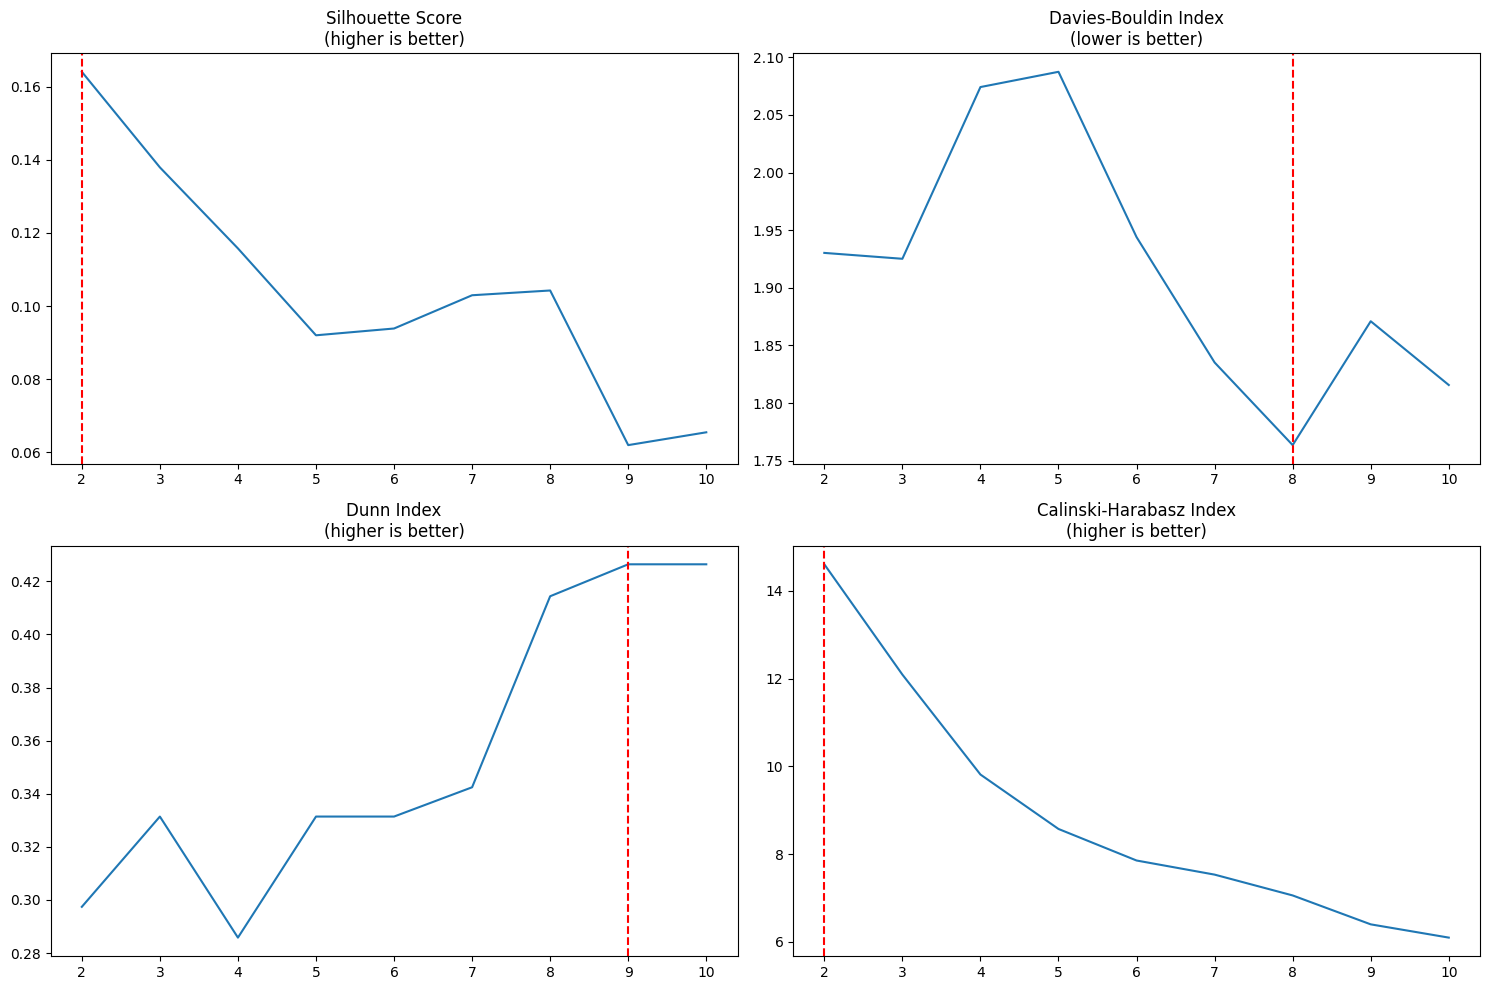


Optimal number of clusters according to different metrics:
silhouette: 2
davies_bouldin: 8
dunn: 9
calinski_harabasz: 2

Note: Current analysis uses 6 clusters, but the Silhouette score suggests 2 clusters might be optimal.
You may want to re-run the analysis with the optimal number of clusters.

Average distance within clusters: 19.48

Cluster Size Distribution:
Min cluster size: 2
Max cluster size: 24
Average cluster size: 10.0
Cluster size standard deviation: 7.5

Potential outlier clusters (significantly smaller than average):
Cluster_2: 2 members
Cluster_5: 2 members


In [12]:
X_scaled = scaler.fit_transform(features_df)

# Evaluate both K-means and Hierarchical clustering
kmeans_metrics = evaluate_clustering(X_scaled, results['kmeans_labels'], "K-means")
hierarchical_metrics = evaluate_clustering(X_scaled, results['hierarchical_labels'], "Hierarchical")

# Print the evaluation results
print("\nClustering Quality Metrics:")
print_clustering_metrics(kmeans_metrics, "K-means")
print_clustering_metrics(hierarchical_metrics, "Hierarchical")

# Find optimal number of clusters
print("\nAnalyzing optimal number of clusters...")
optimal_k, metric_results = find_optimal_clusters(X_scaled)

print("\nOptimal number of clusters according to different metrics:")
for metric, k in optimal_k.items():
    print(f"{metric}: {k}")

# Compare current clustering with optimal number
if optimal_k['silhouette'] != 6:  # Since you used n_clusters=6
    print(f"\nNote: Current analysis uses 6 clusters, but the Silhouette score suggests {optimal_k['silhouette']} clusters might be optimal.")
    print("You may want to re-run the analysis with the optimal number of clusters.")

# Calculate average metrics across all clusters
avg_distance_within_clusters = np.mean([info['avg_distance'] for info in cluster_analysis.values()])
print(f"\nAverage distance within clusters: {avg_distance_within_clusters:.2f}")

# Additional cluster quality insights
print("\nCluster Size Distribution:")
cluster_sizes = [info['size'] for info in cluster_analysis.values()]
print(f"Min cluster size: {min(cluster_sizes)}")
print(f"Max cluster size: {max(cluster_sizes)}")
print(f"Average cluster size: {np.mean(cluster_sizes):.1f}")
print(f"Cluster size standard deviation: {np.std(cluster_sizes):.1f}")

# Identify potential outliers (clusters with very few members)
small_clusters = [cluster for cluster, info in cluster_analysis.items() if info['size'] < np.mean(cluster_sizes)/2]
if small_clusters:
    print("\nPotential outlier clusters (significantly smaller than average):")
    for cluster in small_clusters:
        print(f"{cluster}: {cluster_analysis[cluster]['size']} members")